In [1]:
from os import getcwd
from os.path import join, abspath

from copy import deepcopy
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn.functional as F

from src.data.load_dataset import load_mnist, load_kmnist
from src.models.networks import V1_mnist_RFNet, classical_RFNet
from src.models.utils import train, test

In [2]:
torch.cuda.current_device()

0

In [4]:
data_dir = abspath(join(getcwd(), '../../'))
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [5]:
# load data
train_batch_size, train_percentage = 60000, 0.999
train_loader, val_loader, test_loader = load_kmnist(train_batch_size, train_percentage)

# training params
hidden_size = 1000
num_epochs = 30
step_size, gamma = 5, 0.5 # lr scheduler
num_trials = 5
log_interval = 100
lr = 1E-1
loss_fn = F.cross_entropy

/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## V1 RFNet

In [6]:
# declare model
s, f = 5.32, 1.965
scale = 2 / 784
model = V1_mnist_RFNet(hidden_size, s, f, center=None, scale=scale, seed=10).to(device)
model.v1_layer.weight.requires_grad = True

# declare optimizer and learning rate
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# train and test
V1_train_loss = np.array([])
V1_test_error = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=True)
    test_err = test(model, device, test_loader, verbose=True)
    
    V1_train_loss = np.append(V1_train_loss, loss)
    V1_test_error[epoch] = test_err

RuntimeError: CUDA out of memory. Tried to allocate 230.00 MiB (GPU 0; 11.91 GiB total capacity; 183.03 MiB already allocated; 67.69 MiB free; 202.00 MiB reserved in total by PyTorch)

## Classical Net

In [10]:
## define the model
inp_size = (1, 28, 28)
scale = 2 / 784
model = classical_RFNet(inp_size, hidden_size, scale=scale).to(device)
model.RF_layer.weight.requires_grad = True

# define the optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# train and test
classical_train_loss = np.array([])
classical_test_error = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=True)
    test_err = test(model, device, test_loader, verbose=True)
    
    classical_train_loss = np.append(classical_train_loss, loss)
    classical_test_error[epoch] = test_err

Train_epoch: 0 [0/59940 (0%)]	Loss: 2.308899

Test set: Average loss: 0.814871. Accuracy: 7446/10000 (74.46%)

Train_epoch: 1 [0/59940 (0%)]	Loss: 0.414788

Test set: Average loss: 0.684808. Accuracy: 7822/10000 (78.22%)

Train_epoch: 2 [0/59940 (0%)]	Loss: 0.341078

Test set: Average loss: 0.604611. Accuracy: 8089/10000 (80.89%)

Train_epoch: 3 [0/59940 (0%)]	Loss: 0.279521

Test set: Average loss: 0.549342. Accuracy: 8273/10000 (82.73%)

Train_epoch: 4 [0/59940 (0%)]	Loss: 0.246989

Test set: Average loss: 0.510590. Accuracy: 8409/10000 (84.09%)

Train_epoch: 5 [0/59940 (0%)]	Loss: 0.217710

Test set: Average loss: 0.485933. Accuracy: 8490/10000 (84.90%)

Train_epoch: 6 [0/59940 (0%)]	Loss: 0.200652

Test set: Average loss: 0.464297. Accuracy: 8587/10000 (85.87%)

Train_epoch: 7 [0/59940 (0%)]	Loss: 0.173146

Test set: Average loss: 0.446103. Accuracy: 8641/10000 (86.41%)

Train_epoch: 8 [0/59940 (0%)]	Loss: 0.141077

Test set: Average loss: 0.426350. Accuracy: 8711/10000 (87.11%)

T

Text(0, 0.5, 'Test error')

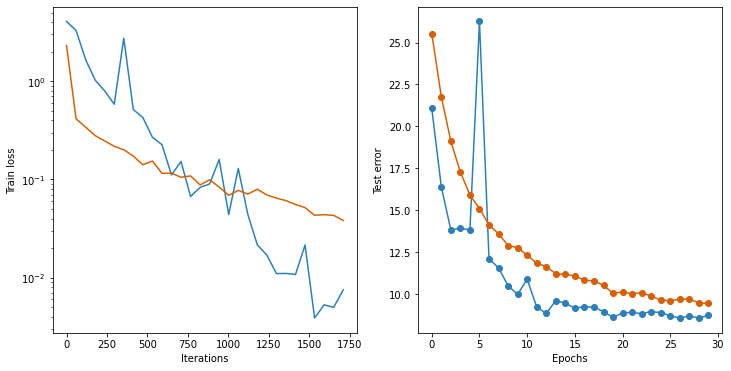

In [11]:
# plot the losses
fig = plt.figure(figsize=(12, 6))

num_batches = len(train_loader)
t = np.arange(len(train_loader) * num_epochs)
ax = fig.add_subplot(121)
plt.semilogy(t[::num_batches], V1_train_loss[::num_batches], '-', c='#2c7fb8')
plt.semilogy(t[::num_batches], classical_train_loss[::num_batches], '-', c='#d95f02')
plt.xlabel('Iterations')
plt.ylabel('Train loss')

t = np.arange(num_epochs)
ax = fig.add_subplot(122)
plt.plot(t, 100 - V1_test_error, '-o', c='#2c7fb8')
plt.plot(t, 100 - classical_test_error, '-o', c='#d95f02')
plt.xlabel('Epochs')
plt.ylabel('Test error')